In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Get raw data

In [2]:
import tushare as ts

token = 'c5cba6dd1dc9c4c3578cdd046f54dfc4119fef2aabf7f998ed9a5192'
ts.set_token(token)
pro = ts.pro_api(token)

df=pro.daily(ts_code='000001.SZ', start_date='20030101',
               end_date='20190106')

df.index = pd.to_datetime(df.trade_date)
df.sort_index(ascending=True,inplace = True)  #####

df.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,,
2003-01-02,000001.SZ,20030102,10.35,10.35,9.99,10.03,10.49,-0.46,-4.39,64848.85,65629.6488
2003-01-03,000001.SZ,20030103,10.00,10.10,9.91,10.02,10.03,-0.01,-0.10,49594.69,49522.8547
2003-01-06,000001.SZ,20030106,10.03,10.12,9.91,10.06,10.02,0.04,0.40,36553.07,36626.6662
2003-01-07,000001.SZ,20030107,10.06,10.15,10.01,10.04,10.06,-0.02,-0.20,27149.59,27361.4667
2003-01-08,000001.SZ,20030108,10.00,10.74,10.00,10.53,10.04,0.49,4.88,80421.70,83768.8306


# Hyperparameters

In [216]:
LR = 0.0001
EPOCH = 100
EARLY_STOP = True
EARLY_STOP_STEP = 20
TRAIN_END = -256
DAYS_BEFORE = 32
DAYS_PRED = 8

# Get data and normolize

In [37]:
def getData(df, column, train_end=-256, days_before=32, days_pred=8,return_all=True, generate_index=False):
    series = df[column].copy()
    
    #train set
    data = pd.DataFrame()
    
    #prepare days
    for i in range(days_before):
        #print(i, i - days_before - days_pred)
        data['b%d' % i] = series.tolist()[i: i - days_before - days_pred]
    
    #predict day
    for i in range(days_pred):
        data['y%d' % i] = series.tolist()[days_before + i : -days_pred+i]
        
    # is index?
    if generate_index:
        data.index = series.index[days_before:]
    
    train_data, val_data, test_data = data[:train_end-256],data[train_end-256:train_end],data[train_end:]
    
    if return_all:
        return train_data, val_data,test_data, series, df.index.tolist()
    
    return train_data, val_data, test_data

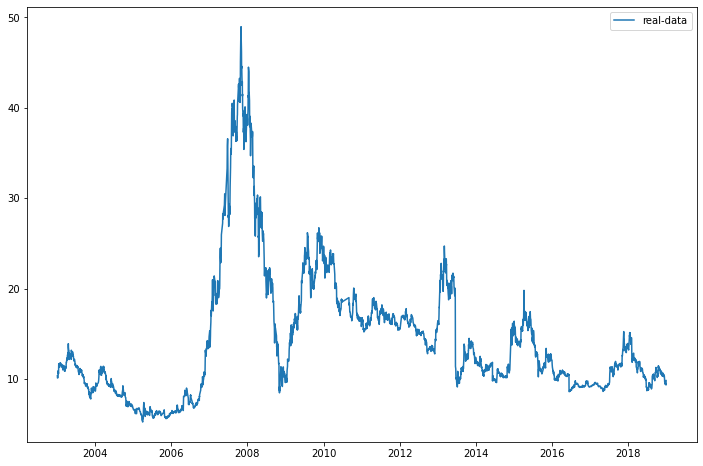

In [38]:
#GET DATA
train_data, val_data,test_data, all_series, df_index = getData(df,'high', days_before=DAYS_BEFORE, days_pred=DAYS_PRED, train_end=TRAIN_END)

#raw data
all_series_test1 = np.array(all_series.copy().tolist())

plt.figure(figsize=(12,8))
plt.plot(df_index, all_series_test1, label='real-data')
plt.legend()

In [39]:
#normolize

# train_mean, train_std
train_data_numpy = np.array(train_data)
train_mean = np.mean(train_data_numpy)
train_std = np.std(train_data_numpy)
train_data_numpy = (train_data_numpy - train_mean) / train_std
train_data_tensor = torch.Tensor(train_data_numpy)

val_data_numpy = np.array(val_data)
val_data_numpy = (val_data_numpy - train_mean) / train_std
val_data_tensor = torch.Tensor(val_data_numpy)

test_data_numpy = np.array(train_data)
test_data_numpy = (test_data_numpy - train_mean) / train_std
test_data_tensor = torch.Tensor(test_data_numpy)

In [40]:
print('training set shape:', train_data.shape)
print('validation set shape:', val_data.shape)
print('test set shape:', test_data.shape)

training set shape: (3183, 40)
validation set shape: (256, 40)
test set shape: (256, 40)


# Dataloader

In [41]:
class TrainSet(Dataset) :
    def __init__(self, data):
        self.data, self.label = data[:, :-DAYS_PRED].float(), data[:, -DAYS_PRED:].float()
        
    def __getitem__(self, index):
        return self.data[index],self.label[index]
    
    def __len__(self):
        return len(self.data)

In [42]:
train_set = TrainSet(train_data_tensor)
train_loader = DataLoader(train_set, batch_size = 256, shuffle=True)

val_set = TrainSet(val_data_tensor)
val_loader = DataLoader(val_set,batch_size=128, shuffle=True)

In [58]:
for tx,ty in train_loader:
    print(tx.shape)
    print(ty.shape)
    break

torch.Size([256, 32])
torch.Size([256, 8])


# Define my model

In [250]:
class dilation_Model(nn.Module):
    def __init__(self):
        super(dilation_Model, self).__init__()
        
        #################################
        self.dilation = nn.Sequential(
            
            nn.ConstantPad1d(padding = (2,0),value = 0),
            nn.Conv1d(in_channels = 1, 
                          out_channels = 1,
                              kernel_size = 3,
                               stride = 1,
                               dilation=1,
                              ),
            
            nn.ConstantPad1d(padding = (4,0),value = 0),
            nn.Conv1d(in_channels = 1, 
                          out_channels = 1,
                              kernel_size = 3,
                               stride = 1,
                               dilation=2,
                              ),
            
            nn.ConstantPad1d(padding = (8,0),value = 0),
            nn.Conv1d(in_channels = 1, 
                          out_channels = 1,
                              kernel_size = 3,
                               stride = 1,
                               dilation=4,
                              ),
            
            nn.ConstantPad1d(padding = (16,0),value = 0),
            nn.Conv1d(in_channels = 1, 
                          out_channels = 1,
                              kernel_size = 3,
                               stride = 1,
                               dilation=8,
                              ),
            
            nn.ConstantPad1d(padding = (32,0),value = 0),
            nn.Conv1d(in_channels = 1, 
                          out_channels = 1,
                              kernel_size = 3,
                               stride = 1,
                               dilation=16,
                              ),
    
        )        
        
        ################################
        self.lstm = nn.LSTM(
        input_size = 1,
        hidden_size = 128,
        num_layers= 1,
        batch_first = True)
        
        
        #################################
        self.dense = nn.Sequential(nn.Linear(128, 1))
        
    def forward(self, x):
                               
        #x = self.dilation(x)
        x = x.transpose(1,2)
        r_out, (h_n, h_c) = self.lstm(x, None)   # 'None' stands for use all zeros as hidden state input
        out = self.dense(r_out[:, -8:, :])     
        
        return out

In [251]:
#test model
model = dilation_Model()

In [252]:
model.parameters

<bound method Module.parameters of dilation_Model(
  (dilation): Sequential(
    (0): ConstantPad1d(padding=(2, 0), value=0)
    (1): Conv1d(1, 1, kernel_size=(3,), stride=(1,))
    (2): ConstantPad1d(padding=(4, 0), value=0)
    (3): Conv1d(1, 1, kernel_size=(3,), stride=(1,), dilation=(2,))
    (4): ConstantPad1d(padding=(8, 0), value=0)
    (5): Conv1d(1, 1, kernel_size=(3,), stride=(1,), dilation=(4,))
    (6): ConstantPad1d(padding=(16, 0), value=0)
    (7): Conv1d(1, 1, kernel_size=(3,), stride=(1,), dilation=(8,))
    (8): ConstantPad1d(padding=(32, 0), value=0)
    (9): Conv1d(1, 1, kernel_size=(3,), stride=(1,), dilation=(16,))
  )
  (lstm): LSTM(1, 128, batch_first=True)
  (dense): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)>

In [253]:
model = dilation_Model()

# put model into cuda
if torch.cuda.is_available():
    model = model.cuda

############optimizer and loss function###############
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
loss_func = nn.MSELoss()

best_loss = np.inf
##################################################

if not os.path.exists('weights'):
    os.mkdir('weights')

early_stop_now = 0 

for epoch in range(EPOCH):
    print("--"*60)
    step = 0
    # trainning
    for tx, ty in train_loader:
    
        if torch.cuda.is_available():
            tx = tx.cuda()
            ty = ty.cuda()
            
        output = model(torch.unsqueeze(tx, dim = 1)) 
        loss = loss_func(torch.squeeze(output), ty)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 10 == 0:
            print('epoch : %d  ' %epoch, 'step : %d' %step, 'train_loss :  %.4f' % loss.cpu().item())
            
        step += 1
        
    # validation
    with torch.no_grad():
        for tx, ty in val_loader:
            if torch.cuda.is_available():
                tx = tx.cuda()
                ty = ty.cuda()
                
            output = model(torch.unsqueeze(tx, dim=1))     #unsqueeze: returns a new tensor with a dimension of size one inserted at the specified position
            loss = loss_func(torch.squeeze(output), ty)        #squeeze: retures a tensor with all the dim of input of sieze 1 removed
            
            print('epoch : %d ' % epoch, 'val_loss : %.4f' % loss.cpu().item())
            
            if loss.cpu().item() < best_loss:
                early_stop_now = 0
                best_loss = loss.cpu().item()
                torch.save(model.state_dict(), 'weights/dilation.pkl')
                print('new model saved at epoch {} with val_loss {}'.format(epoch, best_loss))
            else:
                early_stop_now += 1
                
    if EARLY_STOP and early_stop_now > EARLY_STOP_STEP:
        print('***************warning: early stop**************')
        break

------------------------------------------------------------------------------------------------------------------------
epoch : 0   step : 0 train_loss :  1.0180
epoch : 0   step : 10 train_loss :  1.1297
epoch : 0  val_loss : 0.4118
new model saved at epoch 0 with val_loss 0.41179701685905457
epoch : 0  val_loss : 0.4399
------------------------------------------------------------------------------------------------------------------------
epoch : 1   step : 0 train_loss :  0.9641
epoch : 1   step : 10 train_loss :  0.8731
epoch : 1  val_loss : 0.4211
epoch : 1  val_loss : 0.3877
new model saved at epoch 1 with val_loss 0.3876504898071289
------------------------------------------------------------------------------------------------------------------------
epoch : 2   step : 0 train_loss :  0.8227
epoch : 2   step : 10 train_loss :  0.8389
epoch : 2  val_loss : 0.3890
epoch : 2  val_loss : 0.3719
new model saved at epoch 2 with val_loss 0.3719373345375061
---------------------------

In [254]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(
        input_size = 1,
        hidden_size = 128,
        num_layers= 1,
        batch_first = True)
        
        self.out = nn.Sequential(
        nn.Linear(128,1))
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.lstm(x, None)   # 'None' stands for use all zeros as hidden state input
        out = self.out(r_out[:, -7:, :])                     # use the last day as output
        
        return out

In [222]:
tx, ty =next(iter(train_loader))

In [230]:
rnn = LSTM()

In [231]:
output = rnn(torch.unsqueeze(tx, dim = 2)) 
output.shape

torch.Size([256, 7, 1])

In [232]:
tx.shape

torch.Size([256, 32])